# Annolid on Detectron2 Tutorial 3 : Evaluating the model

This is modified from the official colab tutorial of detectron2. Here, we will 

* Evaluate our previously trained model.

You can make a copy of this tutorial by "File -> Open in playground mode" and play with it yourself. __DO NOT__ request access to this tutorial.


In [1]:
# Is running in colab or in jupyter-notebook
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.10 ; cuda:  cu102
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.10/index.html


In [3]:
# import some common libraries
import json
import os
import cv2
import random
import glob
import numpy as np
if IN_COLAB:
  from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


In [5]:
# is there a gpu
if torch.cuda.is_available():
    GPU = True
    print('gpu available')
else:
    GPU = False
    print('no gpu')

gpu available


## Upload a labeled dataset.
The following code is expecting the dataset in the COCO format to be in a ***.zip*** file. For example: ```sample_dataset.zip``` \
Note: please make sure there is no white space in your file path if you encounter file not found issues.

In [6]:
!pip install gdown 
!gdown --id 1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR

Downloading...
From: https://drive.google.com/uc?id=1fUXCLnoJ5SwXg54mj0NBKGzidsV8ALVR
To: /home/jeremy/Documents/annolid/book/tutorials/novelctrlk6_8_coco_dataset.zip
100%|██████████████████████████████████████| 10.3M/10.3M [00:00<00:00, 97.5MB/s]


In [7]:
if IN_COLAB:
    dataset = '/content/novelctrlk6_8_coco_dataset.zip'
else:
    dataset = 'novelctrlk6_8_coco_dataset.zip'

In [8]:
if IN_COLAB:
    !unzip $dataset -d /content/
else:
    #TODO generalize this
    !unzip -o $dataset -d .

Archive:  novelctrlk6_8_coco_dataset.zip
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00001416_41.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004233_81.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004515_22.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000636_6.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006297_11.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006818_79.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006056_25.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00006094_12.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00004340_96.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000557_50.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00000979_94.jpg  
  inflating: ./novelctrlk6_8_coco_dataset/valid/JPEGImages/00005018_19.jpg  
  inflating: ./novelctrlk6_8_coco_da

In [9]:
DATASET_NAME = DATASET_DIR = f"{dataset.replace('.zip','')}"

In [10]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import get_detection_dataset_dicts
from detectron2.data.datasets import  builtin_meta

In [11]:
register_coco_instances(f"{DATASET_NAME}_train", {}, f"{DATASET_DIR}/train/annotations.json", f"{DATASET_DIR}/train/")
register_coco_instances(f"{DATASET_NAME}_valid", {}, f"{DATASET_DIR}/valid/annotations.json", f"{DATASET_DIR}/valid/")

In [12]:
_dataset_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
_dataset_metadata.thing_colors = [cc['color'] for cc in builtin_meta.COCO_CATEGORIES]

In [13]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_train"])

[01/24 14:31:51 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json
[01/24 14:31:51 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.
[01/24 14:31:51 d2.data.build]: Distribution of instances among all 7 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |    nose    | 118          |  left_ear  | 118          |
|  right_ear   | 117          | tail_base  | 119          |   mouse    | 118          |
|   centroid   | 1            |            |              |            |              |
|    total     | 591          |            |              |            |              |


In [14]:
NUM_CLASSES = len(_dataset_metadata.thing_classes)
print(f"{NUM_CLASSES} Number of classes in the dataset")

7 Number of classes in the dataset


## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the validation dataset. First, let's create a predictor using the model we just trained:

In [15]:
if GPU:
    !nvidia-smi

Mon Jan 24 14:31:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:C1:00.0 Off |                  N/A |
| 24%   34C    P8    20W / 250W |    429MiB /  7979MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
from detectron2.engine import DefaultTrainer

In [17]:
cfg = get_cfg()

In [18]:
if GPU:
    pass
else:
    cfg.MODEL.DEVICE='cpu'

In [19]:
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2 #@param
cfg.DATALOADER.SAMPLER_TRAIN = "RepeatFactorTrainingSampler"
cfg.DATALOADER.REPEAT_THRESHOLD = 0.3
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH =  4 #@param
cfg.SOLVER.BASE_LR = 0.0025 #@param # pick a good LR
cfg.SOLVER.MAX_ITER = 3000 #@param    # 300 iterations seems good enough for 100 frames dataset; you will need to train longer for a practical dataset
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 #@param 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32 #@param   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES  #  (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[01/24 14:31:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/24 14:31:54 d2.data.datasets.coco]: Loaded 118 images in COCO format from novelctrlk6_8_coco_dataset/train/annotations.json
[01/24 14:31:54 d2.data.build]: Removed 0 images with no usable annotations. 118 images left.
[01/24 14:31:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/24 14:31:54 d2.data.build]: Using training sampler RepeatFactorTrainingSampler
[01/24 14:31:54 d2.data.common]: Serializing 118 elements to byte tensors and concatenating them all ...
[01/24 14:31:54 d2.data.common]: Serialized dataset takes 0.31 MiB
WARNING [01/24 14:31:54 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (28, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (28,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) 

In [20]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. 
# We simply update the weights with the newly trained ones to perform inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# set a custom testing threshold
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15   #@param {type: "slider", min:0.0, max:1.0, step: 0.01}
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

In [21]:
from detectron2.utils.visualizer import ColorMode

[01/24 14:31:55 d2.data.datasets.coco]: Loaded 60 images in COCO format from novelctrlk6_8_coco_dataset/valid/annotations.json
[01/24 14:31:55 d2.data.build]: Removed 0 images with no usable annotations. 60 images left.
[01/24 14:31:55 d2.data.build]: Distribution of instances among all 7 categories:
|   category   | #instances   |  category  | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| _background_ | 0            |    nose    | 60           |  left_ear  | 60           |
|  right_ear   | 60           | tail_base  | 60           |   mouse    | 60           |
|   centroid   | 0            |            |              |            |              |
|    total     | 300          |            |              |            |              |


/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jeremy/anaconda3/envs/annolid-env/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


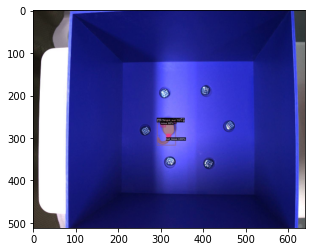

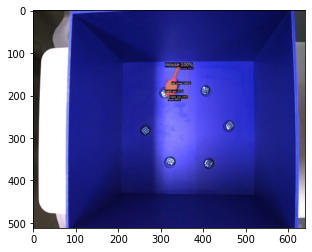

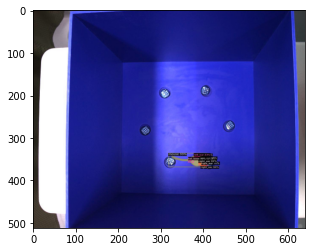

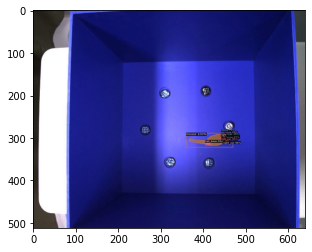

In [22]:
dataset_dicts = get_detection_dataset_dicts([f"{DATASET_NAME}_valid"])
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=_dataset_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    if IN_COLAB:
        cv2_imshow(out.get_image()[:, :, ::-1])
    else:
        plt.imshow(out.get_image()[:, :, ::-1])
        plt.show()
        

A more robust way to evaluate the model is to use a metric called Average Precision (AP) already implemented in the detectron2 package. If you want more precision on what the AP is, you can take a look [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) and [here](https://en.wikipedia.org/w/index.php?title=Information_retrieval&oldid=793358396#Average_precision). 

### #TODO: expand on  how to interpret AP

In [23]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In [24]:
if IN_COLAB:
    evaluator = COCOEvaluator(f"{DATASET_NAME}_valid", cfg, False, output_dir="/content/eval_output/")
else:
    evaluator = COCOEvaluator(f"{DATASET_NAME}_valid", cfg, False, output_dir="eval_output/")

val_loader = build_detection_test_loader(cfg, f"{DATASET_NAME}_valid")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [01/24 14:31:56 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/24 14:31:56 d2.data.datasets.coco]: Loaded 60 images in COCO format from novelctrlk6_8_coco_dataset/valid/annotations.json
[01/24 14:31:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/24 14:31:56 d2.data.common]: Serializing 60 elements to byte tensors and concatenating them all ...
[01/24 14:31:56 d2.data.common]: Serialized dataset takes 0.15 MiB
[01/24 14:31:56 d2.evaluation.evaluator]: Start inference on 60 batches
[01/24 14:31:57 d2.evaluation.evaluator]: Inference done 11/60. Dataloading: 0.0008 s/iter. Inference: 0.0523 s/iter. Eval: 0.0180 s/iter. Total: 0.0712 s/iter. ETA=0:00:03
[01/24 14:32:01 d2.evaluation.evaluator]: Total inference time: 0:00:03.823960 (0.069527 s / iter per device